# Cluster DE

In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [3]:
gene = anndata.read_h5ad("../../data/notebook/revision/gene.h5ad")
isoform = anndata.read_h5ad("../../data/notebook/revision/isoform.h5ad")

In [4]:
isoform = isoform[:,isoform.var.sort_values("gene_id").index]
gene = gene[:,gene.var.sort_values("gene_id").index]

In [5]:
print(isoform.shape)
print(gene.shape)

(6160, 69172)
(6160, 19190)


In [6]:
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ks_2samp, ttest_ind
import numpy as np
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')



def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment
    
    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features) 
    """
    if axis==0 and len(targets) != mat.shape[axis]: return -1
    if axis==1 and len(targets) != mat.shape[axis]: return -1
        
    mask = targets == target
    
    if axis==0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask] # complement matrix
    elif axis==1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask] # complement matrix
    
    return (t_mat, c_mat)

def correct_pval(pval, method):
    nfeat = pval.shape[1]
    
    if method == 'benjamini-hochberg':
        _, pval_corr, _, _ = multipletests(pval, alpha=0.01, method='fdr_bh')
    elif method == 'bonferroni':
        pval_corr = np.minimum(pval * nfeat, 1.0)
        
    return pval_corr

def dexpress(mat, components, features, assignments, **kwargs):
    """
    mat: ndarray
    components: nparray
    features: nparray
    assignments: nparray, length is equal to length of components
    """
    nan_cutoff = kwargs.get("nan_cutoff", 0)
    
    unique = np.unique(assignments)
        
    ncomp = components.shape[0]
    nfeat = features.shape[0]
    nuniq = unique.shape[0]
    
    pval = np.empty((nuniq, nfeat)) # unique assignments by features 
    pval_corr = np.empty((nuniq, nfeat)) # unique assignments by features 
    stat = np.empty((nuniq, nfeat)) # unique assignments by features 
    
    pval.fill(np.nan)
    pval_corr.fill(np.nan)
    stat.fill(np.nan)

    for tidx, t in enumerate(unique):
        logging.debug("{} of {} assignments: {}".format(tidx+1, nuniq, t))
        t_mat, c_mat = split_by_target(mat, assignments, t, axis=0)
        
        pvalue = np.nan
        statistic = np.nan

        # Keep only the genes for which it is in at least nan_cutoff*ncellsinclusters
        mask = np.asarray((t_mat>0).sum(axis=0) > nan_cutoff*t_mat.shape[0]).reshape(-1)

        t_mat_f = t_mat[:, mask]
        c_mat_f = c_mat[:, mask]
        # if "Ccnl2-205_ENSMUST00000139066" in features[mask]:
        #     m = np.where(features[mask]=="Ccnl2-205_ENSMUST00000139066")[0][0]
        #     print(m, np.where(features[mask]=="Ccnl2-205_ENSMUST00000139066"))
        #     print(u, "HERE!!!: ", (t_mat_f[:,m]>0).sum()/t_mat_f.shape[0])
        # added
        
        # added
        if mask.sum()>0:
            test = ttest_ind(t_mat_f, c_mat_f, nan_policy="propagate", equal_var=False)
            pvalue = test.pvalue
            statistic = test.statistic
                
        pval[tidx,:][mask] = pvalue
        stat[tidx,:][mask] = statistic
    
    return (pval, stat)

In [7]:
gene = gene[gene.obs.subclass_label=="L6 CT"]
isoform = isoform[isoform.obs.subclass_label=="L6 CT"]

In [8]:
%%time
mat           = gene.layers["log1p"].todense()
components    = gene.obs.cell_id.values
gene_features = gene.var.gene_name.values
assignments   = gene.obs.cluster_label.values

unique = np.unique(assignments)
nan_cutoff = 0.90 # of elements in cluster
corr_method = "bonferroni"


p_gene_raw, stat = dexpress(mat, components, gene_features, assignments, 
                      nan_cutoff=nan_cutoff)

p_gene = correct_pval(p_gene_raw, corr_method)
s_gene = stat

22-Oct-20 17:12:30 - 1 of 5 assignments: L6 CT Gpr139
22-Oct-20 17:12:30 - 2 of 5 assignments: L6 CT Grp_1
22-Oct-20 17:12:31 - 3 of 5 assignments: L6 CT Grp_2
22-Oct-20 17:12:31 - 4 of 5 assignments: L6 CT Nxph2_1
22-Oct-20 17:12:31 - 5 of 5 assignments: L6 CT Nxph2_2


CPU times: user 493 ms, sys: 396 ms, total: 888 ms
Wall time: 884 ms


In [9]:
%%time
mat         = isoform.layers["log1p"].todense() # expects dense matrix
components  = isoform.obs.cell_id.values
features    = isoform.var.transcript_name.values
assignments = isoform.obs.cluster_label.values

unique = np.unique(assignments)
nan_cutoff = 0.90 # of elements in cluster
corr_method = "bonferroni"


p_isoform_raw, stat = dexpress(mat, components, features, assignments, 
                      nan_cutoff=nan_cutoff)

p_isoform = correct_pval(p_isoform_raw/2, corr_method)
s_isoform = stat

22-Oct-20 17:12:32 - 1 of 5 assignments: L6 CT Gpr139
22-Oct-20 17:12:32 - 2 of 5 assignments: L6 CT Grp_1
22-Oct-20 17:12:32 - 3 of 5 assignments: L6 CT Grp_2
22-Oct-20 17:12:33 - 4 of 5 assignments: L6 CT Nxph2_1
22-Oct-20 17:12:33 - 5 of 5 assignments: L6 CT Nxph2_2


CPU times: user 1.02 s, sys: 1.1 s, total: 2.12 s
Wall time: 2.12 s


In [10]:
# Want to make a mask to return the isoforms for which the isoform is differential but the gene is not

In [11]:
repeat_col = gene.var["num_isoforms"]

p1 = p_isoform
p2 = np.repeat(p_gene, repeat_col, axis=1)

s1 = s_isoform
s2 = np.repeat(s_gene, repeat_col, axis=1)

In [12]:
alpha = 0.01
tcrit = 0


bool_mask = np.ones(p1.shape, dtype=bool)

p1_mask = np.logical_and(p1<alpha, s1>tcrit)

p2_mask = np.logical_or(np.logical_and(p2>alpha, s2>tcrit), np.logical_and(p2<alpha, s2<tcrit))

mask = np.logical_and(p1_mask, p2_mask)
bool_mask = mask

In [13]:
bool_mask.sum()

41

In [14]:
unique

array(['L6 CT Gpr139', 'L6 CT Grp_1', 'L6 CT Grp_2', 'L6 CT Nxph2_1',
       'L6 CT Nxph2_2'], dtype=object)

In [15]:
markers_isoform = pd.DataFrame(index=unique, columns=["transcript_name", "p_raw", "p_bonferroni"])

In [16]:
assignments = gene.obs.cluster_label
unique = np.unique(assignments)

In [17]:
unique

array(['L6 CT Gpr139', 'L6 CT Grp_1', 'L6 CT Grp_2', 'L6 CT Nxph2_1',
       'L6 CT Nxph2_2'], dtype=object)

In [18]:
isoform_features = isoform.var.transcript_name.values

for uidx, u in enumerate(unique):
    mask = np.logical_and(bool_mask[uidx], bool_mask.sum(axis=0)==1)
    
    p = p_isoform[uidx][mask]
    p_raw = p_isoform_raw[uidx][mask]
    
    psort = np.argsort(p)
    
    fsorted = isoform_features[mask][psort]
    psorted = p[psort]
    p_raw_sorted = p_raw[psort]
    
    markers_isoform.loc[u]["transcript_name"] = fsorted
    markers_isoform.loc[u]["p_raw"] = p_raw_sorted
    markers_isoform.loc[u]["p_bonferroni"] = psorted

In [19]:
markers_isoform

,transcript_name,p_raw,p_bonferroni
L6 CT Gpr139,"[4833439L19Rik-201_ENSMUST00000026989, Nell2-2...","[4.479496172792454e-09, 8.281453989676631e-09,...","[0.00015492785463219982, 0.0002864223676869559..."
L6 CT Grp_1,"[Homer1-204_ENSMUST00000102752, Actb-201_ENSMU...","[1.216809621061458e-11, 1.3495250620950517e-09...","[4.2084577554031584e-07, 4.667467379761946e-05..."
L6 CT Grp_2,"[Prdx5-203_ENSMUST00000149261, Myt1l-202_ENSMU...","[9.308135395567038e-12, 2.765969471267141e-09,...","[3.219311707910816e-07, 9.566382013324534e-05,..."
L6 CT Nxph2_1,"[Pik3r1-201_ENSMUST00000035532, Ttc3-230_ENSMU...","[2.2495955048304282e-11, 3.274442103229751e-08...","[7.780451013006519e-07, 0.0011324985458230417,..."
L6 CT Nxph2_2,"[Hlf-201_ENSMUST00000004051, Ntm-209_ENSMUST00...","[6.403011582788474e-10, 2.4078215350303936e-07]","[2.2145455860232218e-05, 0.00832769156105612]"


In [20]:
isoform.obs.cluster_label.value_counts()[0:10]

L6 CT Grp_1      781
L6 CT Nxph2_1     68
L6 CT Grp_2       24
L6 CT Gpr139      21
L6 CT Nxph2_2     10
Name: cluster_label, dtype: int64

In [21]:
cluster = "L6 CT Grp_1"

[[i.split("_")[0] + "_" + i.split("_")[1]]  for i in markers_isoform.loc[cluster]["transcript_name"]]

[['Homer1-204_ENSMUST00000102752'],
 ['Actb-201_ENSMUST00000100497'],
 ['Mkl2-204_ENSMUST00000149359'],
 ['Nmt2-201_ENSMUST00000081932'],
 ['Klf13-201_ENSMUST00000063694'],
 ['Atp2b1-207_ENSMUST00000219557']]

In [22]:
specific_cluster = cluster
specific_isoform = "Homer1-204_ENSMUST00000102752"
specific_gene = "".join(specific_isoform.split("-")[:-1])

In [23]:
gene.var[gene.var.gene_name.str.contains(specific_gene+"_")].gene_name.values

array(['Homer1_ENSMUSG00000007617'], dtype=object)

In [24]:
specific_gene = gene.var[gene.var.gene_name.str.contains(specific_gene+"_")].gene_name.values[0]

In [25]:
logger.setLevel(logging.ERROR)

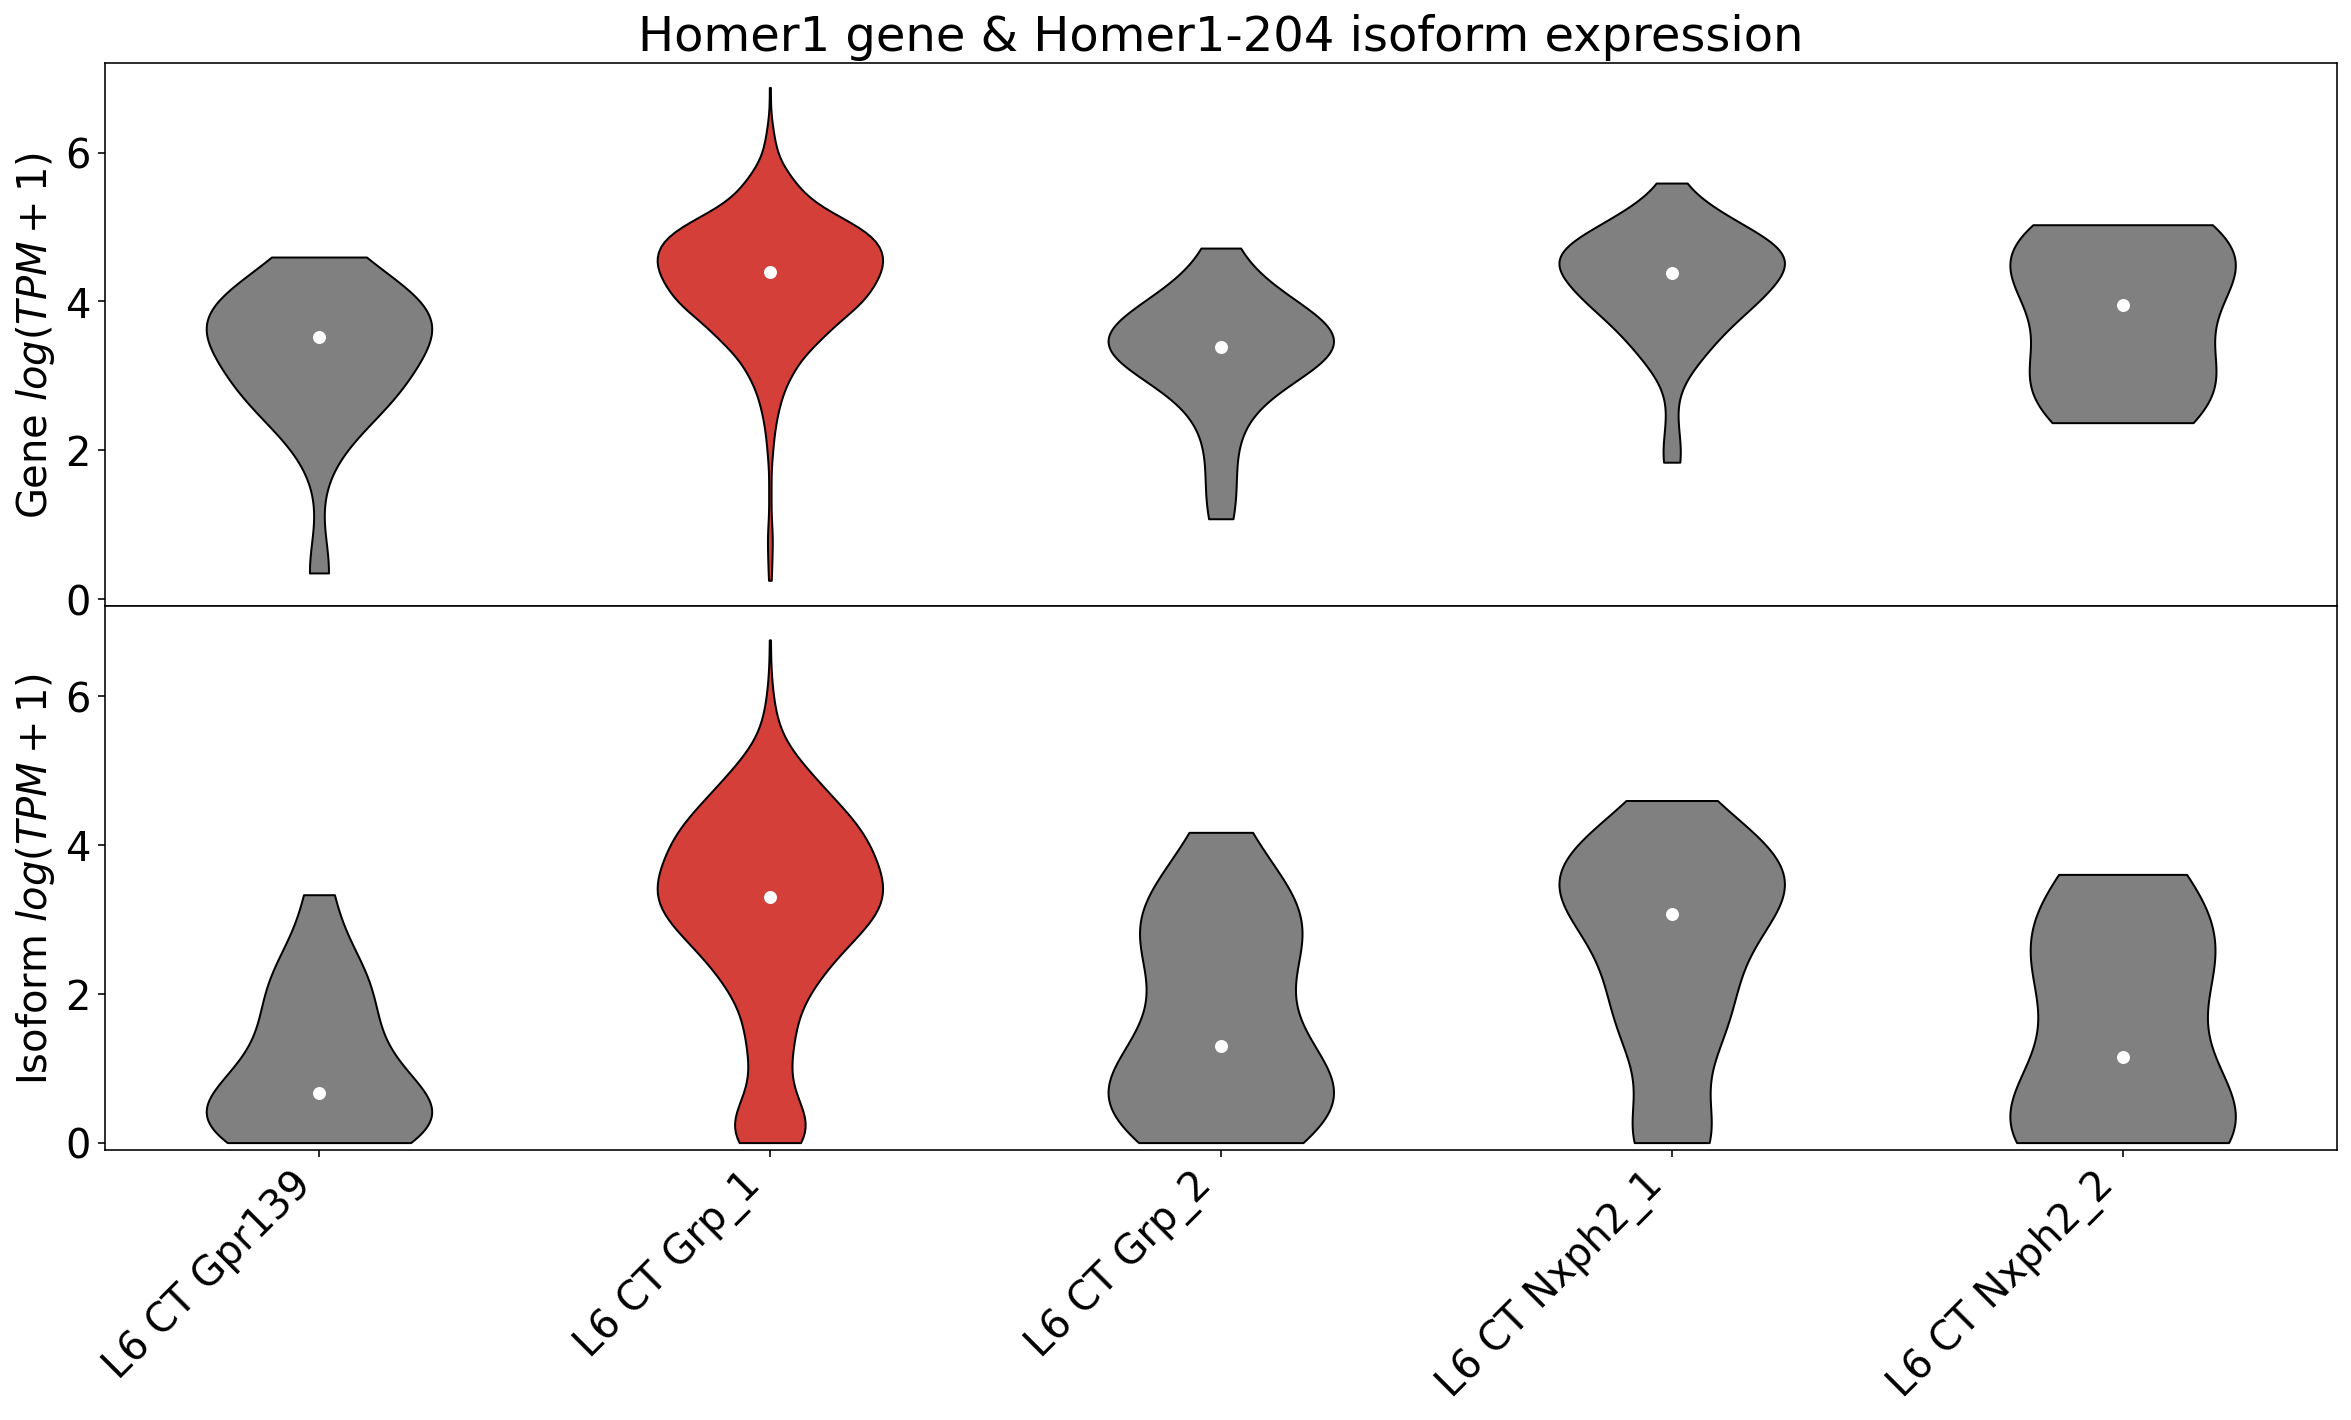

In [26]:
fig, ax = plt.subplots(figsize=(20,10), nrows=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

unique = np.unique(gene.obs.cluster_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))
labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]
#######3# Gene
x = []
for c in unique:
    x.append(np.asarray(gene[gene.obs.cluster_label==c][:,gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

parts = ax[0].violinplot(x, showmedians=False, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor("#D43F3A")

medians = [np.median(i) for i in x]
ax[0].scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)

#ax[0].axhline(y=medians[midx], color="k")
ax[0].set_ylabel("Gene $log(TPM + 1)$")

######## Isoform
x = []
for c in unique:
    x.append(np.asarray(isoform[isoform.obs.cluster_label==c][:,isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())

parts = ax[1].violinplot(x, showmedians=False, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor("#D43F3A")

ax[0].set_ylim(-0.1)
medians = [np.median(i) for i in x]
ax[1].scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)
ax[1].set_xticks(lidx)
ax[1].set_xticklabels(labels, rotation=45, ha="right")
ax[1].set_ylabel("Isoform $log(TPM + 1)$")
ymin, ymax = ax[0].get_ylim()
ax[1].set_ylim((ymin, ymax))
ax[0].set_title("{} gene & {} isoform expression".format(specific_gene.split("_")[0], specific_isoform.split("_")[0]))
plt.savefig("../../figures/cluster_DE_violin_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [27]:
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from matplotlib import cm

In [28]:
num_NCA = 2
state = 42
num_PCA = 100

In [29]:
X = gene.X

tsvd = TruncatedSVD(n_components=num_PCA)
Y = tsvd.fit_transform(X)

In [30]:
# NCA
X = Y
y = gene.obs.cluster_id.values.astype(int)

nca = NeighborhoodComponentsAnalysis(n_components=num_NCA,random_state=state)
YY = nca.fit_transform(X, y)

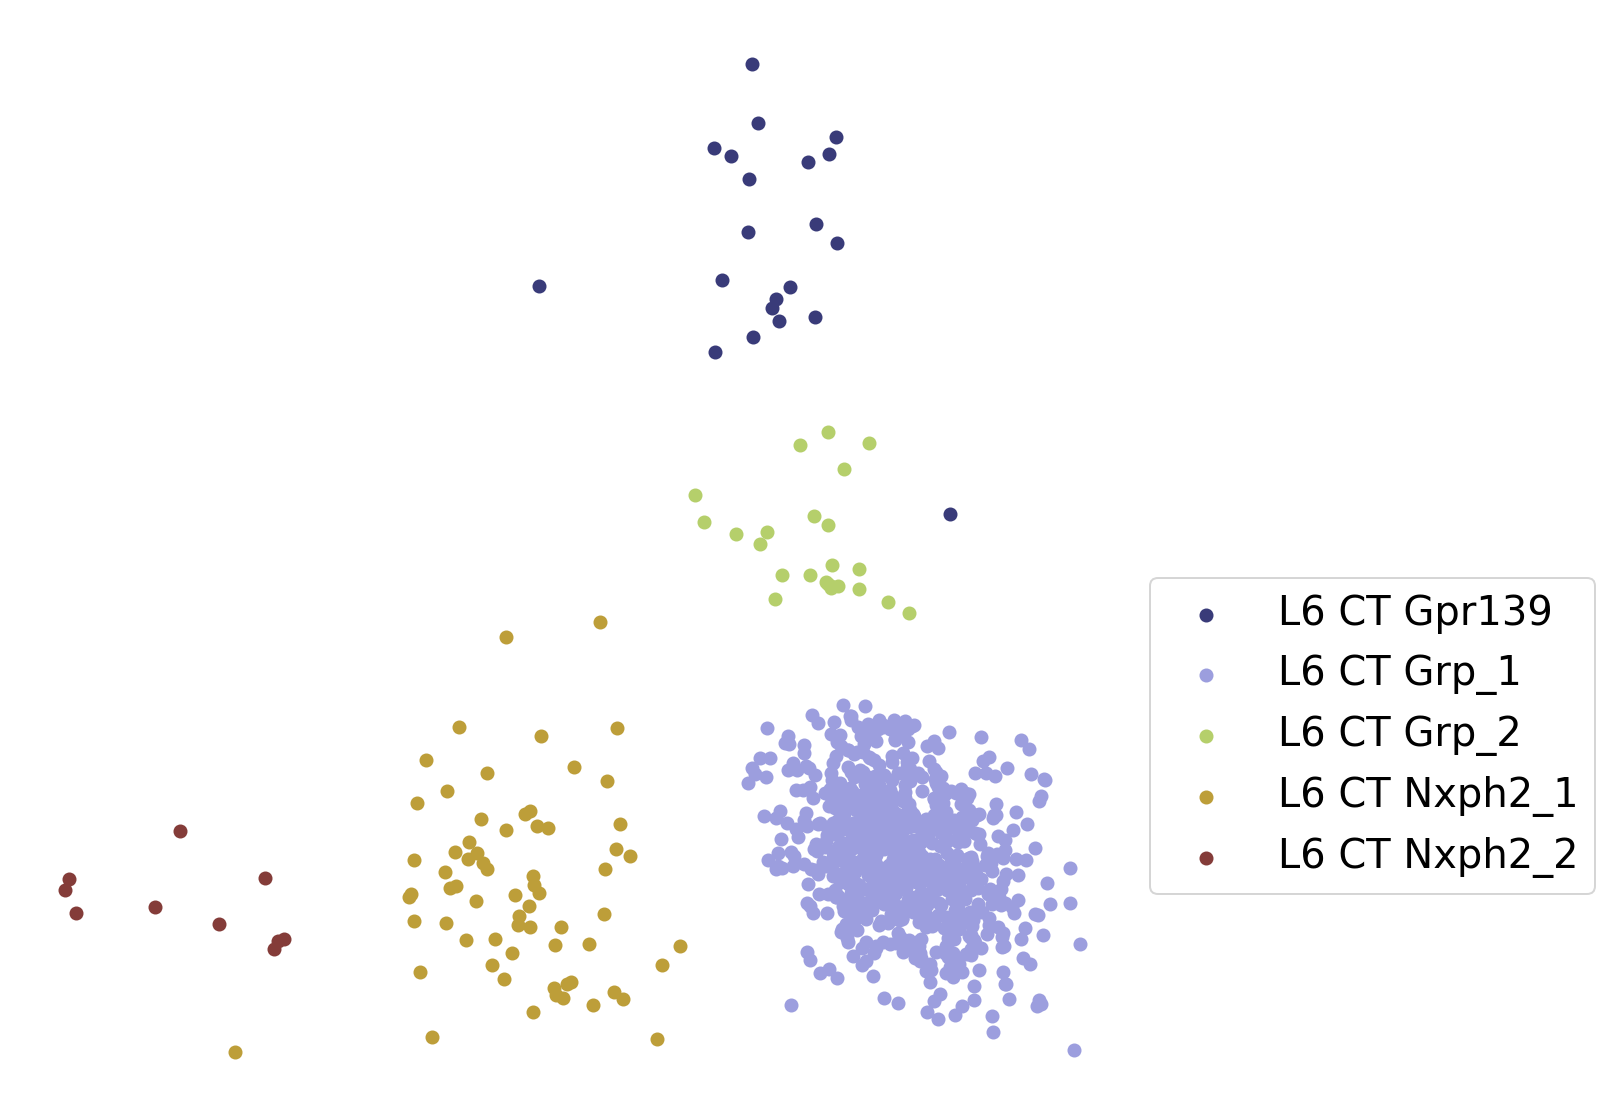

In [31]:
fig, ax = plt.subplots(figsize=(10,10))

x = YY[:,0]
y = YY[:,1]
c = cm.get_cmap("tab20b")
assignments = gene.obs.cluster_label.values
unique = np.unique(assignments)

for uidx, u in enumerate(unique):
    mask = assignments==u
    xx = x[mask]
    yy = y[mask]
    ax.scatter(xx, yy, color=c(uidx*3), cmap="tab20b", label=u)


ax.legend(bbox_to_anchor=(1, 0.5))

ax.set_axis_off()
plt.show()

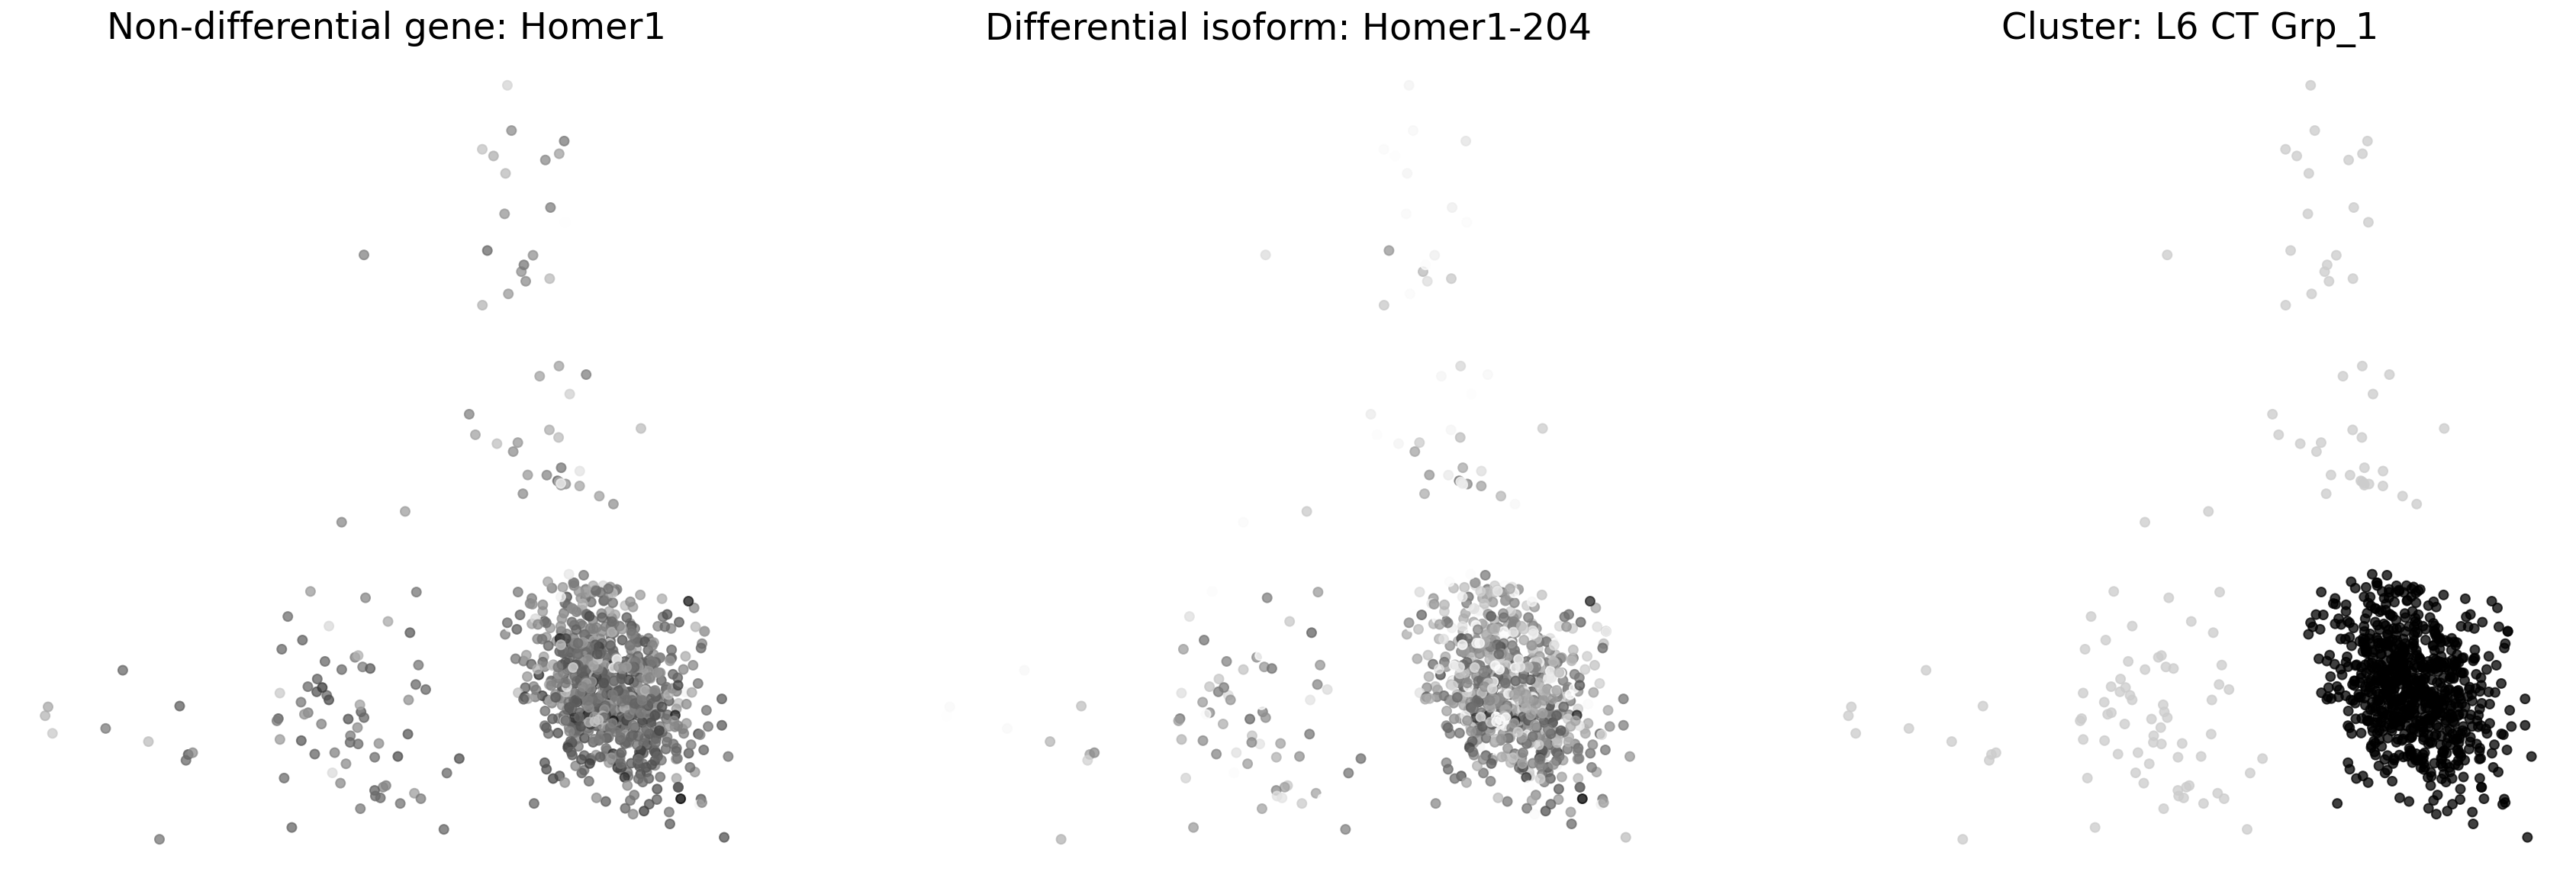

In [32]:
complement_color = (0.8, 0.8, 0.8, 1.0)

fig, ax = plt.subplots(figsize=(30,10), ncols=3)

x = YY[:,0]
y = YY[:,1]
c = np.asarray(gene[:, gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[0].set_title("Non-differential gene: {}".format(specific_gene.split("_")[0]))

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()


x = YY[:,0]
y = YY[:,1]
c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[1].set_title("Differential isoform: {}".format(specific_isoform.split("_")[0]))

ax[1].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[1].set_axis_off()

x = YY[:,0]
y = YY[:,1]

c = gene.obs["cluster_id"].values.astype(int)
c = gene.obs["cluster_label"]==specific_cluster

alpha=0.75
cmap="nipy_spectral_r"

ax[2].scatter(x, y, c=c, cmap=cmap, alpha=alpha)

ax[2].set_axis_off()
ax[2].set_title("Cluster: {}".format(specific_cluster))
plt.savefig("../../figures/cluster_DE_nca_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [33]:
identified_isoforms = markers_isoform["transcript_name"].explode().astype(str)
identified_isoforms = identified_isoforms[identified_isoforms!="nan"]

In [34]:
identified_genes = identified_isoforms.apply(lambda x: x.split("-")[0:-1][0])

In [35]:
print("{} isoforms from {} genes identified.".format(identified_isoforms.shape[0], identified_genes.nunique()))

41 isoforms from 40 genes identified.


In [36]:
markers_isoform["transcript_name"].explode()

L6 CT Gpr139     4833439L19Rik-201_ENSMUST00000026989
L6 CT Gpr139             Nell2-202_ENSMUST00000166170
L6 CT Gpr139               Ak1-202_ENSMUST00000113277
L6 CT Gpr139     2610301B20Rik-201_ENSMUST00000080517
L6 CT Gpr139             Rbm28-201_ENSMUST00000007993
L6 CT Gpr139             Kcnj6-201_ENSMUST00000095873
L6 CT Gpr139            Creld1-201_ENSMUST00000032422
L6 CT Gpr139              Ctsd-201_ENSMUST00000066401
L6 CT Gpr139             Cisd3-201_ENSMUST00000107583
L6 CT Gpr139            Hpcal4-201_ENSMUST00000059667
L6 CT Gpr139              Emc3-201_ENSMUST00000032425
L6 CT Gpr139            Fbxo44-208_ENSMUST00000167160
L6 CT Gpr139              Nt5m-201_ENSMUST00000102695
L6 CT Gpr139            Hnrnpc-201_ENSMUST00000111610
L6 CT Gpr139           Sec61a2-202_ENSMUST00000102981
L6 CT Gpr139            Fbxo44-201_ENSMUST00000057907
L6 CT Gpr139              Syt1-202_ENSMUST00000105276
L6 CT Gpr139            Mrpl55-203_ENSMUST00000108785
L6 CT Gpr139              Sv

In [37]:
markers_isoform["p_raw"].explode()

L6 CT Gpr139      4.4795e-09
L6 CT Gpr139     8.28145e-09
L6 CT Gpr139     8.37699e-09
L6 CT Gpr139     9.85412e-09
L6 CT Gpr139     1.93649e-08
L6 CT Gpr139     2.55224e-08
L6 CT Gpr139     2.69962e-08
L6 CT Gpr139     3.77382e-08
L6 CT Gpr139     6.06764e-08
L6 CT Gpr139     6.16705e-08
L6 CT Gpr139     7.40285e-08
L6 CT Gpr139     7.74578e-08
L6 CT Gpr139     8.47373e-08
L6 CT Gpr139     8.53558e-08
L6 CT Gpr139     1.03164e-07
L6 CT Gpr139     1.08491e-07
L6 CT Gpr139     1.12631e-07
L6 CT Gpr139     1.70095e-07
L6 CT Gpr139     1.88149e-07
L6 CT Gpr139     2.09938e-07
L6 CT Gpr139     2.16268e-07
L6 CT Gpr139     2.24499e-07
L6 CT Grp_1      1.21681e-11
L6 CT Grp_1      1.34953e-09
L6 CT Grp_1      3.24556e-09
L6 CT Grp_1      1.25424e-08
L6 CT Grp_1      4.90026e-08
L6 CT Grp_1      1.32604e-07
L6 CT Grp_2      9.30814e-12
L6 CT Grp_2      2.76597e-09
L6 CT Grp_2      2.93659e-08
L6 CT Grp_2      3.05998e-08
L6 CT Grp_2      1.85909e-07
L6 CT Grp_2      2.21351e-07
L6 CT Grp_2   

In [38]:
markers_isoform = markers_isoform.apply(pd.Series.explode).reset_index()

In [39]:
markers_isoform

,index,transcript_name,p_raw,p_bonferroni
0,L6 CT Gpr139,4833439L19Rik-201_ENSMUST00000026989,4.4795e-09,0.000154928
1,L6 CT Gpr139,Nell2-202_ENSMUST00000166170,8.28145e-09,0.000286422
2,L6 CT Gpr139,Ak1-202_ENSMUST00000113277,8.37699e-09,0.000289727
3,L6 CT Gpr139,2610301B20Rik-201_ENSMUST00000080517,9.85412e-09,0.000340815
4,L6 CT Gpr139,Rbm28-201_ENSMUST00000007993,1.93649e-08,0.000669755
5,L6 CT Gpr139,Kcnj6-201_ENSMUST00000095873,2.55224e-08,0.000882716
6,L6 CT Gpr139,Creld1-201_ENSMUST00000032422,2.69962e-08,0.000933692
7,L6 CT Gpr139,Ctsd-201_ENSMUST00000066401,3.77382e-08,0.00130522
8,L6 CT Gpr139,Cisd3-201_ENSMUST00000107583,6.06764e-08,0.00209855
9,L6 CT Gpr139,Hpcal4-201_ENSMUST00000059667,6.16705e-08,0.00213293


In [40]:
markers_isoform.to_csv("../../tables/unordered/cluster_DE.csv")